# Digit Recognizer using Neural Network

## Imports and loading the data

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# check if cuda available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# set random seed
torch.manual_seed(1)

cuda


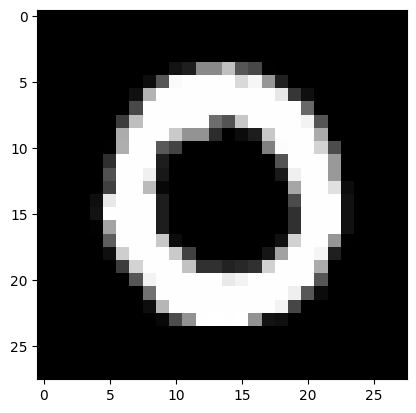

In [13]:
# Load data
train = pd.read_csv('data/train.csv')
y = train['label']
X = train.drop('label', axis=1)
X = X / 255
X_test = pd.read_csv('data/test.csv')
X_test = X_test / 255

plt.imshow(X.values[1,:].reshape(28,28), cmap='gray')

In [14]:
## make data loader using my own dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=70, shuffle=True)
test_dataset = MyDataset(X_test, pd.DataFrame(np.zeros(len(X_test))))
test_loader = DataLoader(test_dataset, batch_size=140, shuffle=False)

## My model

In [15]:
# Define model that can process MNSIT dataset 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 7 * 7)
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/500.. Train loss: 1.847
Epoch 2/500.. Train loss: 0.517
Epoch 3/500.. Train loss: 0.349
Epoch 4/500.. Train loss: 0.295
Epoch 5/500.. Train loss: 0.258
Epoch 6/500.. Train loss: 0.226
Epoch 7/500.. Train loss: 0.199
Epoch 8/500.. Train loss: 0.177
Epoch 9/500.. Train loss: 0.158
Epoch 10/500.. Train loss: 0.143
Epoch 11/500.. Train loss: 0.130
Epoch 12/500.. Train loss: 0.119
Epoch 13/500.. Train loss: 0.109
Epoch 14/500.. Train loss: 0.101
Epoch 15/500.. Train loss: 0.094
Epoch 16/500.. Train loss: 0.089
Epoch 17/500.. Train loss: 0.084
Epoch 18/500.. Train loss: 0.079
Epoch 19/500.. Train loss: 0.075
Epoch 20/500.. Train loss: 0.071
Epoch 21/500.. Train loss: 0.069
Epoch 22/500.. Train loss: 0.066
Epoch 23/500.. Train loss: 0.063
Epoch 24/500.. Train loss: 0.061
Epoch 25/500.. Train loss: 0.059
Epoch 26/500.. Train loss: 0.057
Epoch 27/500.. Train loss: 0.055
Epoch 28/500.. Train loss: 0.053
Epoch 29/500.. Train loss: 0.051
Epoch 30/500.. Train loss: 0.050
Epoch 31/500.. Trai

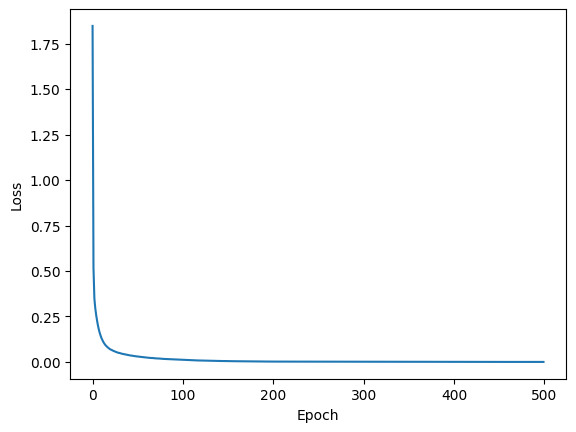

In [16]:
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

# Train the model
n_epochs = 500
train_losses = []
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.view(-1, 1, 28, 28))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{n_epochs}.. "
          f"Train loss: {running_loss / len(train_loader):.3f}")

# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [17]:
# predict 

model.eval()
preds = []
for i, data in enumerate(test_loader, 0):
    inputs, _ = data
    inputs = inputs.to(device)
    outputs = model(inputs.view(-1, 1, 28, 28))
    _, predicted = torch.max(outputs, 1)
    preds.extend(predicted.cpu().numpy())

# Save predictions to file
submission = pd.DataFrame({'ImageId': range(1, len(X_test) + 1), 'Label': preds})
submission.to_csv('submission.csv', index=False)